In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score

In [2]:
movies = pd.read_csv(
    "movies.dat",
    sep="::",
    engine="python",
    names=["movieId", "title", "genres"]
)

ratings = pd.read_csv(
    "ratings.dat",
    sep="::",
    engine="python",
    names=["userId", "movieId", "rating", "timestamp"]
)

tags = pd.read_csv(
    "tags.dat",
    sep="::",
    engine="python",
    names=["userId", "movieId", "tag", "timestamp"]
)

In [3]:
print("Movies shape:", movies.shape)
print("Ratings shape:", ratings.shape)
print("Tags shape:", tags.shape)

movies.head()

Movies shape: (10681, 3)
Ratings shape: (10000054, 4)
Tags shape: (95580, 4)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.isnull().sum()
ratings.isnull().sum()
tags.isnull().sum()

userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

In [5]:
tags["tag"] = tags["tag"].fillna("")


In [6]:
movies["genres"] = movies["genres"].str.replace("|", " ", regex=False)

movies["content"] = movies["title"] + " " + movies["genres"]

movies[["title", "genres", "content"]].head()

,title,genres,content
0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Toy Story (1995) Adventure Animation Children ...
1,Jumanji (1995),Adventure Children Fantasy,Jumanji (1995) Adventure Children Fantasy
2,Grumpier Old Men (1995),Comedy Romance,Grumpier Old Men (1995) Comedy Romance
3,Waiting to Exhale (1995),Comedy Drama Romance,Waiting to Exhale (1995) Comedy Drama Romance
4,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II (1995) Comedy


In [7]:
train_ratings, test_ratings = train_test_split(
    ratings,
    test_size=0.2,
    random_state=42
)

In [8]:
tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=40000, 
    ngram_range=(1, 3),
    min_df=1
)



In [9]:
tags_grouped = tags.groupby("movieId")["tag"].apply(
    lambda x: " ".join(x)
).reset_index()

movies = movies.merge(
    tags_grouped,
    on="movieId",
    how="left"
)

movies["tag"] = movies["tag"].fillna("")

movies["content"] = (
    movies["title"] + " " +
    movies["genres"] + " " +
    movies["tag"]
)

In [10]:
movieid_to_index = dict(zip(movies["movieId"], movies.index))
movieid_to_title = dict(zip(movies["movieId"], movies["title"]))

In [11]:
tfidf_matrix = tfidf.fit_transform(movies["content"])

In [12]:
tfidf_matrix.shape


(10681, 40000)

In [13]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [14]:
def recommend_similar_movies(movie_id, n=10):
    idx = movieid_to_index[movie_id]

    similarity_scores = list(enumerate(cosine_sim[idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    similarity_scores = similarity_scores[1:n+1]
    movie_indexes = [i[0] for i in similarity_scores]

    return movies.loc[movie_indexes, ["title", "genres"]]

In [15]:
recommend_similar_movies(movie_id=100, n=12)


,title,genres
978,Caught (1996),Drama Thriller
1142,"Bloody Child, The (1996)",Drama Thriller
78,"Juror, The (1996)",Drama Thriller
836,Basquiat (1996),Drama
1032,"Proprietor, The (1996)",Drama
1042,"Sunchaser, The (1996)",Drama
1119,Get Over It (1996),Drama
1524,Gabbeh (1996),Drama
1710,"Further Gesture, A (1996)",Drama
2924,Portraits Chinois (1996),Drama


In [16]:
ratings_movies = ratings.merge(
    movies,
    on="movieId",
    how="inner"
)

ratings_movies.head()


,userId,movieId,rating,timestamp,title,genres,content,tag
0,1,122,5.0,838985046,Boomerang (1992),Comedy Romance,Boomerang (1992) Comedy Romance dating Nudity ...,dating Nudity (Topless - Brief) Can't remember
1,1,185,5.0,838983525,"Net, The (1995)",Action Crime Thriller,"Net, The (1995) Action Crime Thriller computer...",computers computers internet Irwin Winkler San...
2,1,231,5.0,838983392,Dumb & Dumber (1994),Comedy,Dumb & Dumber (1994) Comedy Jeff Daniels Jim C...,Jeff Daniels Jim Carrey stupid Jim Carrey Shit...
3,1,292,5.0,838983421,Outbreak (1995),Action Drama Sci-Fi Thriller,Outbreak (1995) Action Drama Sci-Fi Thriller b...,biology Gross disease Futuristmovies.com disea...
4,1,316,5.0,838983392,Stargate (1994),Action Adventure Sci-Fi,Stargate (1994) Action Adventure Sci-Fi Egypt ...,Egypt space time travel time travel aliens anc...


In [17]:
active_users = ratings_movies["userId"].value_counts()
active_users = active_users[active_users >= 20].index

filtered_ratings = ratings_movies[
    ratings_movies["userId"].isin(active_users)
]


In [18]:
def train_test_split_userwise(data, test_size=0.2):
    train_data = []
    test_data = []

    for user_id in data["userId"].unique():
        user_ratings = data[data["userId"] == user_id]

        if len(user_ratings) < 10:
            continue

        train, test = train_test_split(
            user_ratings,
            test_size=test_size,
            random_state=42
        )

        train_data.append(train)
        test_data.append(test)

    return pd.concat(train_data), pd.concat(test_data)


In [19]:
# Count ratings per user
user_counts = filtered_ratings['userId'].value_counts()

# Keep users with at least 50 ratings
active_users = user_counts[user_counts >= 25].index

ratings_active = filtered_ratings[
    filtered_ratings['userId'].isin(active_users)
]


In [20]:
# Randomly sample users
sampled_users = np.random.choice(
    ratings_active['userId'].unique(),
    size=6000,
    replace=False
)

ratings_sampled = ratings_active[
    ratings_active['userId'].isin(sampled_users)
]


In [21]:
train_data, test_data = train_test_split_userwise(ratings_sampled)

print("Train size:", train_data.shape)
print("Test size:", test_data.shape)


Train size: (750833, 8)
Test size: (190655, 8)


In [22]:
def build_user_profile_train(user_id):
    user_data = train_data[train_data["userId"] == user_id]

    movie_idx_list = []
    ratings_list = []

    for _, row in user_data.iterrows():
        movie_id = row["movieId"]
        if movie_id in movieid_to_index:
            movie_idx_list.append(movieid_to_index[movie_id])
            ratings_list.append(row["rating"])

    if len(movie_idx_list) == 0:
        return None

    movie_idx_list = np.array(movie_idx_list)
    ratings_list = np.array(ratings_list)

    #  Mean-center ratings (bias correction)
    ratings_list = ratings_list - ratings_list.mean()

    user_vector = tfidf_matrix[movie_idx_list].T.dot(ratings_list)

    norm = np.linalg.norm(user_vector)
    if norm == 0:
        return None

    return user_vector / norm


In [23]:
def recommend_movies(user_id, k=10):
    user_vector = build_user_profile_train(user_id)

    if user_vector is None:
        return []

    scores = cosine_similarity(
        user_vector.reshape(1, -1),
        tfidf_matrix
    )[0]

    watched = train_data[
        train_data["userId"] == user_id
    ]["movieId"].values

    watched_indices = {
        movieid_to_index[mid]
        for mid in watched
        if mid in movieid_to_index
    }

    scores[list(watched_indices)] = -1

    top_indices = np.argsort(scores)[-k:][::-1]

    return movies.iloc[top_indices]["movieId"].tolist()


In [24]:
def recommend_movies_with_names(user_id, k=10):
    recommended_ids = recommend_movies(user_id, k)
    return [movieid_to_title[mid] for mid in recommended_ids]


In [25]:
recommend_movies_with_names(user_id=100, k=10)


['Bridge on the River Kwai, The (1957)',
 'Best Years of Our Lives, The (1946)',
 'Sound of Music, The (1965)',
 'Lord of the Rings: The Return of the King, The (2003)',
 'From Here to Eternity (1953)',
 'Lawrence of Arabia (1962)',
 'Mrs. Miniver (1942)',
 'Ben-Hur (1959)',
 'On the Waterfront (1954)',
 'All About Eve (1950)']

In [26]:
def precision_recall_f1_at_k(user_id, k=30):
    recommended = recommend_movies(user_id, k)

    if len(recommended) == 0:
        return None, None, None

    relevant = test_data[
        (test_data["userId"] == user_id) &
        (test_data["rating"] >= 4)
    ]["movieId"].values

    if len(relevant) == 0:
        return None, None, None

    tp = len(set(recommended) & set(relevant))

    # Correct precision definition
    precision = tp / len(recommended)
    recall = tp / len(relevant)

    f1 = 0 if precision + recall == 0 else \
         2 * precision * recall / (precision + recall)

    return precision, recall, f1


In [28]:
np.random.seed(42)

sample_users = np.random.choice(
    test_data["userId"].unique(),
    size=500,
    replace=False
)

precisions, recalls, f1s = [], [], []

for user_id in sample_users:
    p, r, f1 = precision_recall_f1_at_k(user_id, k=10)
    if p is not None:
        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)

print("Average Precision@10:", np.mean(precisions))
print("Average Recall@10:", np.mean(recalls))
print("Average F1@10:", np.mean(f1s))

Average Precision@10: 0.056854838709677426
Average Recall@10: 0.04234904882193081
Average F1@10: 0.04004674936179341


In [30]:
def diversity_at_k(user_id, k=10):
    recs = recommend_movies(user_id, k)

    if len(recs) < 2:
        return None

    # Convert movie IDs to TF-IDF indices
    indices = [
        movieid_to_index[m]
        for m in recs
        if m in movieid_to_index
    ]

    if len(indices) < 2:
        return None

    vectors = tfidf_matrix[indices]
    sim_matrix = cosine_similarity(vectors)

    # Take upper triangle without diagonal
    upper_triangle = sim_matrix[np.triu_indices(len(indices), k=1)]

    return 1 - np.mean(upper_triangle)


In [31]:
diversities = []

for user_id in sample_users:
    d = diversity_at_k(user_id, k=10)
    if d is not None:
        diversities.append(d)

print("Average Diversity@10:", np.mean(diversities))


Average Diversity@10: 0.617816949623295


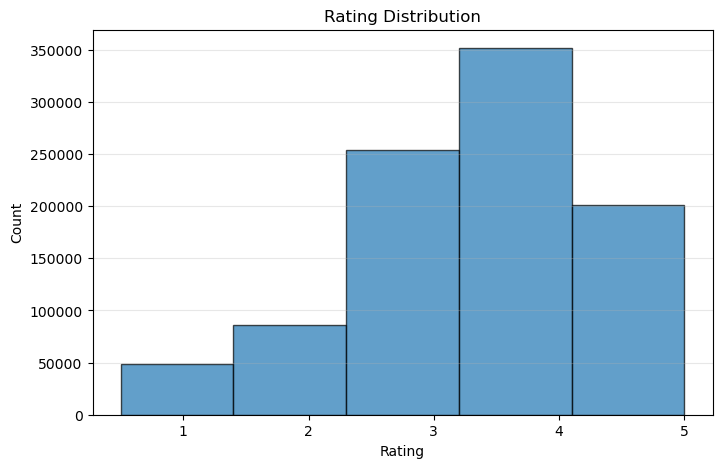

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(ratings_sampled["rating"], bins=5, edgecolor="black", alpha=0.7)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.show()


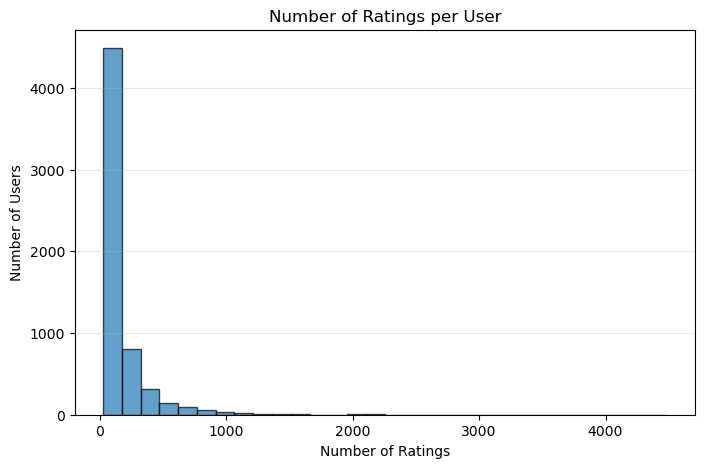

In [33]:
user_counts = ratings_sampled['userId'].value_counts()

plt.figure(figsize=(8,5))
plt.hist(user_counts, bins=30, edgecolor="black", alpha=0.7)
plt.title("Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.grid(axis='y', alpha=0.3)
plt.show()


In [43]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Prepare y_true and y_scores for all test users
y_true_all = []
y_scores_all = []

for user_id in sample_users:  
    # Build user profile
    user_vector = build_user_profile_train(user_id)
    if user_vector is None:
        continue
    
    # Compute scores for all movies
    scores = cosine_similarity(user_vector.reshape(1, -1), tfidf_matrix)[0]
    
    # Get which movies are relevant in test set
    relevant_movies = test_data[(test_data["userId"] == user_id) & (test_data["rating"] >= 4)]["movieId"].values
    y_true = np.zeros(len(movies))
    movie_indices = [movieid_to_index[mid] for mid in relevant_movies if mid in movieid_to_index]
    y_true[movie_indices] = 1
    
    watched = train_data[train_data["userId"] == user_id]["movieId"].values
    watched_indices = [movieid_to_index[mid] for mid in watched if mid in movieid_to_index]
    y_true[watched_indices] = 0  # treat as not relevant
    
    y_true_all.extend(y_true)
    y_scores_all.extend(scores)

y_true_all = np.array(y_true_all)
y_scores_all = np.array(y_scores_all)

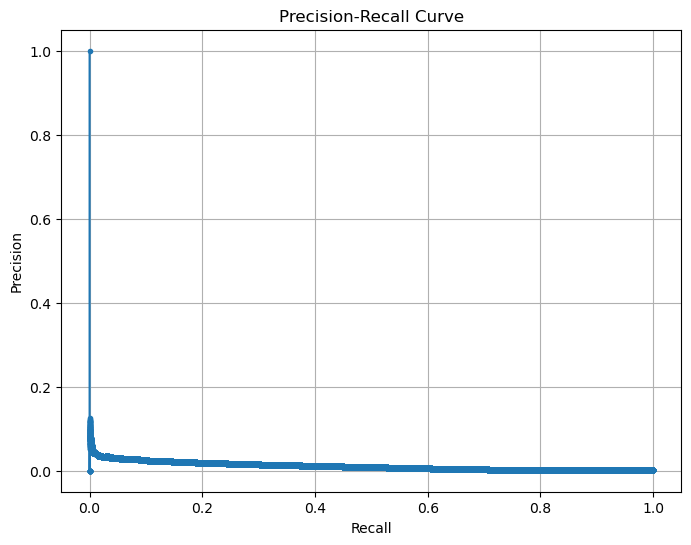

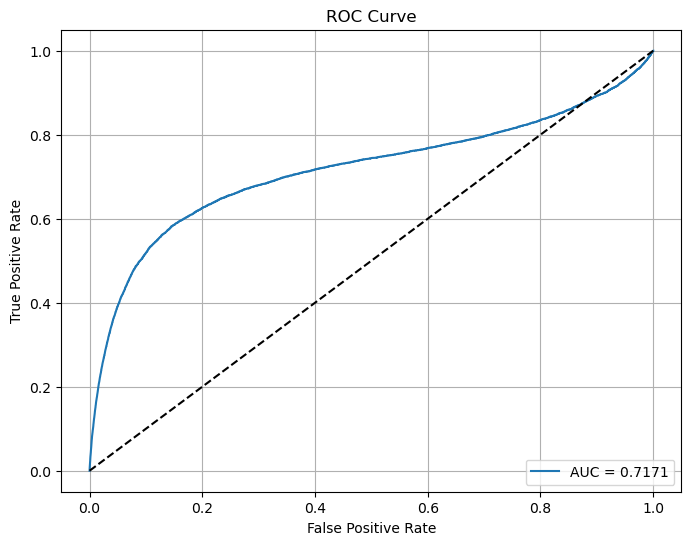

In [44]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_true_all, y_scores_all)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_true_all, y_scores_all)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

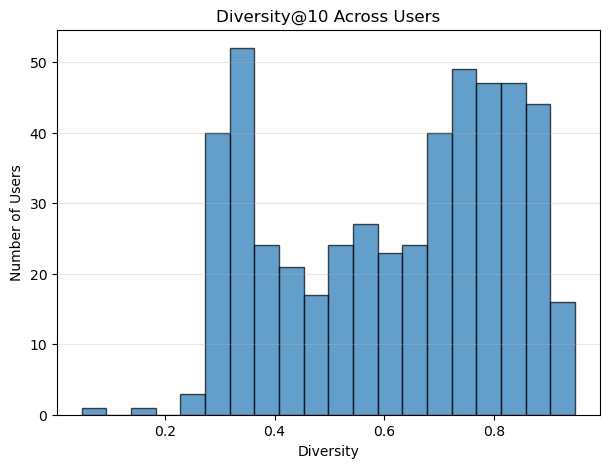

Average Diversity@10: 0.617816949623295


In [45]:
diversities = []
for user_id in sample_users:
    d = diversity_at_k(user_id, k=10)
    if d is not None:
        diversities.append(d)

plt.figure(figsize=(7,5))
plt.hist(diversities, bins=20, edgecolor='black', alpha=0.7)
plt.title("Diversity@10 Across Users")
plt.xlabel("Diversity")
plt.ylabel("Number of Users")
plt.grid(axis='y', alpha=0.3)
plt.show()

print("Average Diversity@10:", np.mean(diversities))
